# Hyper Market DB Query Implementation

In [1]:

# Import packages
import mysql.connector as mysql
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import getpass
import missingno as msn

In [3]:
# establish connection

db = mysql.connect(
    host ='localhost',
    user='root',
    passwd = 'Silu@0305'
)

print(db)

In [6]:
# Create cursor

cursor = db.cursor()

In [8]:
# fetch and show all the databases
cursor.execute('SHOW DATABASES')

all_databases = cursor.fetchall()

for i in all_databases:
    print(i)

('FmsDB',)
('HyperMarket',)
('LabDBMS',)
('LabDBMS2',)
('LabDBMS3',)
('MyProfile',)
('Northwind',)
('Rough',)
('Training',)
('ecommerce',)
('indium_3',)
('information_schema',)
('mysql',)
('performance_schema',)
('sys',)


*Start Here*

In [2]:
# Create a function to establish connection with HyperMarket db

def my_connector(pd, db):
    """Connects to MySQL server

    Returns:
        _buffer_: returns the connection cursor
    """


    m_db = mysql.connect(
        host = 'localhost',
        user = 'root',
        passwd = pd,
        database = db 
    )

    if m_db.is_connected():
        print("Connection successful")
    else:
        print("Opps.. Something went wrong.\n Please try again.")
    
    return m_db

In [3]:
# Let's create a function

def create_df(x):
    """Creates DataFrame from cursor

    Args:
        x : cursor of executed query

    Returns:
        _DataFrame_: Pandas DataFrame
    """
    df = pd.DataFrame(x.fetchall())
    df.columns = [i[0] for i in x.description]
    return df

In [4]:
# call the function and create a cursor
cn = my_connector(pd=getpass.getpass('Password: '),db='HyperMarket')
cur = cn.cursor(buffered=True)

Connection successful


## Basic Queries

### 1. Check the tables in the database

In [6]:
# Check table
cur.execute("SHOW TABLES")


print('Tables and Views: ')
for i in cur.fetchall():

    print(i[0])

Tables and Views: 
brands
cart
categories
customer_segment
customers
details
orders
outlets
products
staffs
stocks


### 2. Total number of records in each table

In [7]:
cur.execute("""
    SELECT 
        TABLE_NAME, 
        TABLE_ROWS 
    FROM 
        INFORMATION_SCHEMA.TABLES 
    WHERE 
        TABLE_SCHEMA = 'HyperMarket'""")



table_name = []
num_records = []

for i in cur.fetchall():
    table_name.append(i[0])
    num_records.append(i[1])


table_details = pd.DataFrame({
    "table_name": table_name,
    "num_records": num_records
})

table_details

,table_name,num_records
0,brands,1026.0
1,cart,19973.0
2,categories,11.0
3,customer_segment,NaN
4,customers,264.0
5,details,NaN
6,orders,5001.0
7,outlets,4.0
8,products,2979.0
9,staffs,42.0


In [8]:
table_details.dropna(inplace=True) # Remove views
table_details.num_records = table_details.num_records.astype('int') # convert num records from float to integer

table_details

,table_name,num_records
0,brands,1026
1,cart,19973
2,categories,11
4,customers,264
6,orders,5001
7,outlets,4
8,products,2979
9,staffs,42
10,stocks,11865


## SQL VIEWS:

To find details about a product or a order we have to join 3 to 4 tables to get the desired outputs.
This becomes time consuming when it comes to a busy day. To elevate this issue we can save the data of a complex join
to a view table. Which we can use any day any time in a local machine. 

Views are handy because <br>
>    i. Similar to table but does not use physical memory.   <br>
>    ii. Simplifies complex queries like joins <br>
>    iii. Access control. <br>
>    iv. Ease of creation and management <br>
>    v. Works like a deep copy of tables. <br>

For this reasons we will create a view with all the necessary fields in it, which will reduce the cost of complex joins every time we try to find something.

**Don't Execute** It's already done

In [ ]:
# Create detailed view 
cur.execute("""
    CREATE VIEW HyperMarket.details AS
        SELECT 
            od.outlet_id,
            ot.city,
            od.order_id,
            od.order_date,
            od.customer_id,
            c1.product_id,
            c1.quantity,
            b.brand_id,
            p.category_id,
            p.price
        FROM
            HyperMarket.outlets ot
        LEFT JOIN
            HyperMarket.orders od ON ot.outlet_id = od.outlet_id
            LEFT JOIN
        HyperMarket.cart c1 ON od.order_id = c1.order_id
            RIGHT JOIN
        HyperMarket.products p ON c1.product_id = p.product_id
            LEFT JOIN
        HyperMarket.brands b ON p.brand_id = b.brand_id
            LEFT JOIN
        HyperMarket.categories c2 ON p.category_id = c2.category_id
""")


In [ ]:
# the view can be dropped using 
# cur.execute("DROP VIEW HyperMarket.details")

In [9]:
# cal the view
cur.execute("SELECT * FROM HyperMarket.details")


detailed_df = pd.DataFrame(cur.fetchall())
detailed_df.columns = [i[0] for i in cur.description]
detailed_df.head()

,outlet_id,city,order_id,order_date,customer_id,product_id,quantity,brand_id,category_id,price
0,ST02,Hyderabad,tx-1196,2022-01-12,ST3ZILW5081,1.0,7.0,BIN1001,4,282.0
1,ST02,Hyderabad,tx-1615,2022-03-14,ST1AFEQ7815,1.0,7.0,BIN1001,4,282.0
2,ST01,Chennai,tx-1808,2022-04-10,ST3GFKH6254,1.0,9.0,BIN1001,4,282.0
3,ST01,Chennai,tx-1842,2022-01-22,ST3UHRX6951,1.0,9.0,BIN1001,4,282.0
4,ST01,Chennai,tx-1879,2022-03-27,ST4IENZ6043,1.0,2.0,BIN1001,4,282.0


In [10]:
# calculate price
detailed_df['total_price'] = detailed_df.quantity * detailed_df.price

detailed_df.head()

,outlet_id,city,order_id,order_date,customer_id,product_id,quantity,brand_id,category_id,price,total_price
0,ST02,Hyderabad,tx-1196,2022-01-12,ST3ZILW5081,1.0,7.0,BIN1001,4,282.0,1974.0
1,ST02,Hyderabad,tx-1615,2022-03-14,ST1AFEQ7815,1.0,7.0,BIN1001,4,282.0,1974.0
2,ST01,Chennai,tx-1808,2022-04-10,ST3GFKH6254,1.0,9.0,BIN1001,4,282.0,2538.0
3,ST01,Chennai,tx-1842,2022-01-22,ST3UHRX6951,1.0,9.0,BIN1001,4,282.0,2538.0
4,ST01,Chennai,tx-1879,2022-03-27,ST4IENZ6043,1.0,2.0,BIN1001,4,282.0,564.0


In [11]:
# Shape of DataFrame
detailed_df.shape

(19974, 11)

In [12]:
# duplicates
detailed_df.duplicated().any()

True

There must be duplicates as each customer buys multiple products in multiple orders

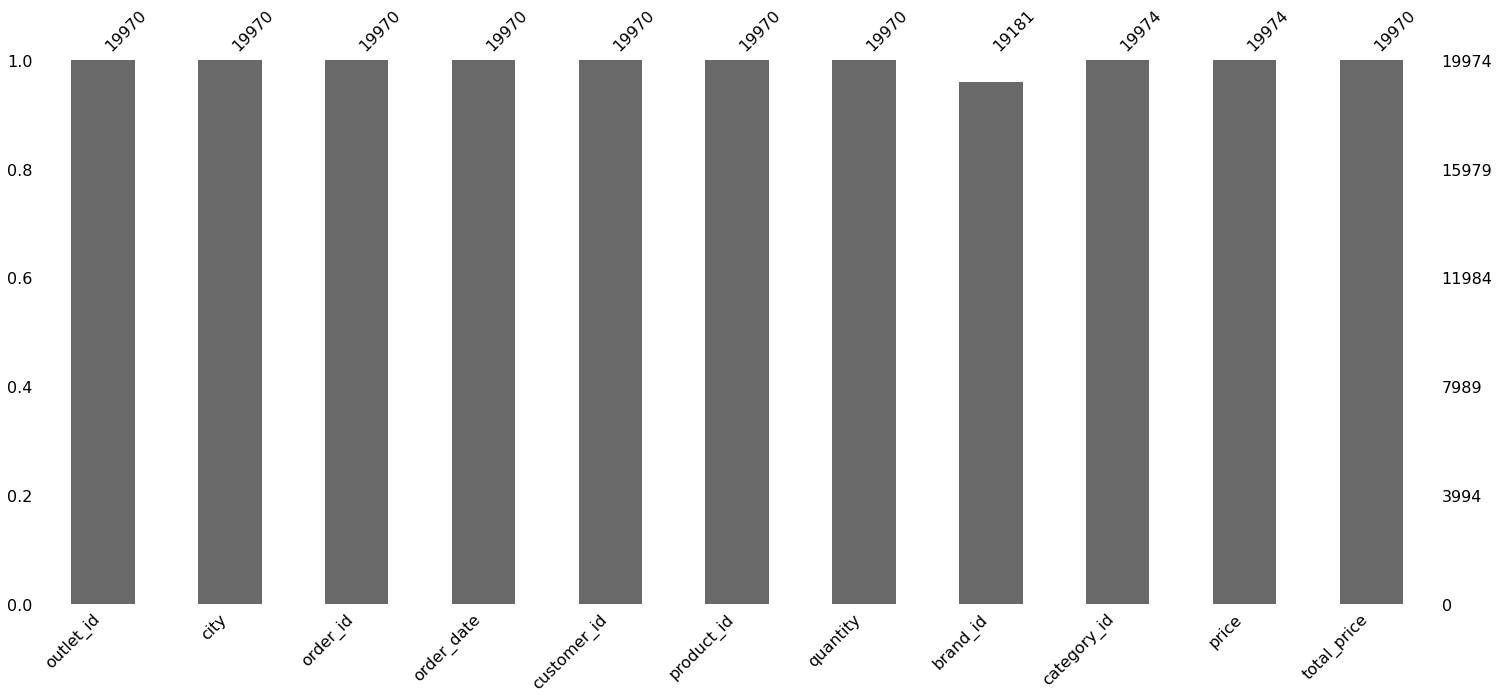

In [13]:
# missing values
msn.bar(detailed_df);

No missing value present

## Stakeholders' Expectations

### Q.1. Top products sold in Chennai and Bengaluru

*Note*: <br>
**Best selling products**: <br>
Ther are two types of best selling products: 
i.e. price wise (sells wise), quantity wise

In [5]:
# quantity wise top selling products

cur.execute("""
    SELECT 
        o.city, 
        p.product_name, 
        SUM(d.quantity) total_sold
    FROM
        HyperMarket.details d
            JOIN
        HyperMarket.products p USING (product_id)
            JOIN
        HyperMarket.outlets o USING (outlet_id)
    WHERE
        o.city IN ('Chennai' , 'Bengaluru')
    GROUP BY 1 , 2
    ORDER BY 3 DESC
    LIMIT 10
""")


top_products_qtty_df = pd.DataFrame(cur.fetchall())
top_products_qtty_df.columns = [i[0] for i in cur.description]
top_products_qtty_df

,city,product_name,total_sold
0,Bengaluru,Ashwagandharishta,56.0
1,Bengaluru,Swiss Milk Mug - Ebony E603,52.0
2,Bengaluru,Chocolate Shake With Real Belgian Chocolate,51.0
3,Bengaluru,Baby Powder,50.0
4,Bengaluru,Dry Pants Diapers - Large,50.0
5,Chennai,Soft Drink,49.0
6,Bengaluru,Doraemon Super Big Plastic Lunch Box - Assorte...,47.0
7,Bengaluru,Pampers Pants Diapers - Medium Size 80pcs + Se...,47.0
8,Chennai,Filter Coffee Powder,46.0
9,Bengaluru,Cheese Cubes,44.0


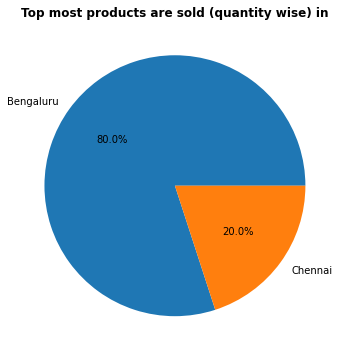

In [25]:
top_products_qtty_df.city.value_counts().plot(kind='pie', labels= top_products_qtty_df.city.unique(), autopct='%1.1f%%', figsize=(6,6))
plt.ylabel('')
plt.title("Top most products are sold (quantity wise) in", fontweight='bold')
plt.show()

In [15]:
# Sells (price) wise top products
cur.execute("""
    SELECT 
        o.city,
        p.product_name,
        ROUND(SUM(d.price * d.quantity), 2) price
    FROM
        HyperMarket.details d
            JOIN
        HyperMarket.products p USING (product_id)
            JOIN
        HyperMarket.outlets o USING (outlet_id)
    WHERE
        o.city IN ('Bengaluru' , 'Chennai')
    GROUP BY 1 , 2
    ORDER BY price DESC
    LIMIT 10"""
)

top_products_price_df = pd.DataFrame(cur.fetchall())
top_products_price_df.columns = [i[0] for i in cur.description]
top_products_price_df

,city,product_name,price
0,Chennai,Dried Prunes,117705.0
1,Bengaluru,Dried Prunes,105315.0
2,Chennai,Mixed Vegetable Pickle,97500.0
3,Bengaluru,Swiss Milk Mug - Ebony E603,88400.0
4,Bengaluru,Ashwagandharishta,83426.0
5,Bengaluru,"Christmas Decorative Tree - Big, 5 Ft",77760.0
6,Chennai,Jelly Tips,72800.0
7,Chennai,Chocolate Flavoured Lubes,68400.0
8,Bengaluru,"Pista - Irani, Roasted & Salted",66642.0
9,Chennai,Ravishing Gold Kit,65527.0


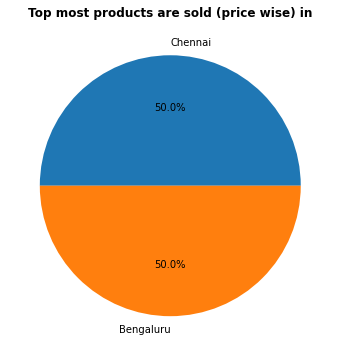

In [24]:
top_products_price_df.city.value_counts().plot(kind='pie', labels= top_products_price_df.city.unique(), autopct='%1.1f%%', figsize=(6,6))
plt.ylabel('')
plt.title("Top most products are sold (price wise) in", fontweight='bold')
plt.show()

### Q.2. Least sold products in Pune and Hyderabad

In [28]:
cur.execute("""
    SELECT 
        o.city, 
        p.product_name, 
        SUM(d.price * d.quantity) price
    FROM
        HyperMarket.details d
            JOIN
        HyperMarket.products p USING (product_id)
            JOIN
        HyperMarket.outlets o USING (outlet_id)
    WHERE
        o.city IN ('Hyderabad' , 'Pune')
    GROUP BY 1 , 2
    ORDER BY price ASC
    LIMIT 10"""
)

least_sold_products = create_df(cur)

least_sold_products

,city,product_name,price
0,Pune,Organic - Aloe Soothing Shampoo,5.0
1,Hyderabad,Probiotic Health Drink - Light,15.0
2,Pune,Strong Garlic Instant Noodles,15.0
3,Hyderabad,Opalware Pudding Set - Silken Charms,24.0
4,Pune,Malai Paneer,25.0
5,Pune,Tender Coconut Tub - Frozen Dessert,28.0
6,Hyderabad,Strong Garlic Instant Noodles,30.0
7,Hyderabad,Basil Seed Drinks - Honey,30.0
8,Hyderabad,Natural & Herbal Henna,30.0
9,Pune,Hair Removal Cream For Normal Skin,30.0


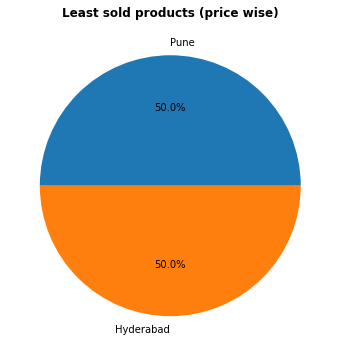

In [30]:
least_sold_products.city.value_counts().plot(kind='pie', labels= least_sold_products.city.unique(), autopct='%1.1f%%', figsize=(6,6))
plt.ylabel('')
plt.title("Least sold products (price wise)", fontweight='bold')
plt.show()

In [38]:
# Quantity wise
cur.execute("""
    WITH least_selling_products AS
    (
    SELECT 
        o.city, 
        p.product_name, 
        SUM(d.quantity) total_sold
    FROM HyperMarket.details d
        JOIN 
        HyperMarket.products p USING (product_id)
        JOIN 
        HyperMarket.outlets o USING (outlet_id)
    WHERE 
        o.city in ('Hyderabad', 'Pune')
    GROUP BY 1,2
    ORDER BY 3 ASC)
    SELECT * FROM least_selling_products 
    WHERE total_sold = (
        SELECT MIN(total_sold) 
        FROM least_selling_products)"""
)

least_sold_qntty_df = create_df(cur)
least_sold_qntty_df

,city,product_name,total_sold
0,Pune,Chicken - Burger,1.0
1,Pune,Prawns - Pud Medium,1.0
2,Pune,Papaya- Diced,1.0
3,Pune,Pizza Cutter - Royal,1.0
4,Hyderabad,Halwa Grater With Container - Green,1.0
...,...,...,...
187,Hyderabad,1-2-3 Noodles - Chicken Flavour,1.0
188,Pune,Chicken Cocktail Sausage,1.0
189,Hyderabad,Rohu Fish Large Curry Cut 1kg +Chilli Chicken ...,1.0
190,Hyderabad,Chicken - Mortadella with Green Olives Sliced,1.0


So many products are barely sold.

Which outlet have more number of least sold products?

In [33]:
least_sold_qntty_df.shape

(192, 3)

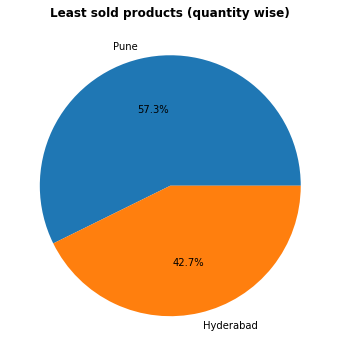

In [34]:
least_sold_qntty_df.city.value_counts().plot(kind='pie', labels= least_sold_qntty_df.city.unique(), autopct='%1.1f%%', figsize=(6,6))
plt.ylabel('')
plt.title("Least sold products (quantity wise)", fontweight='bold')
plt.show()

### Q.3. Customer Segregation

In [6]:
cur.execute('SELECT * FROM customer_segment')

customers_df = create_df(cur)
customers_df.head()

,customer_id,monthly_shopping,customer_category
0,ST2PMSR5412,58181.0,Platinum
1,ST1IELB0962,11781.0,Silver
2,ST1TKPC5768,26479.0,Gold
3,ST1EWSG3297,14087.5,Silver
4,ST2RTKD1903,37119.0,Gold


In [8]:
customers_df.shape

(188, 3)

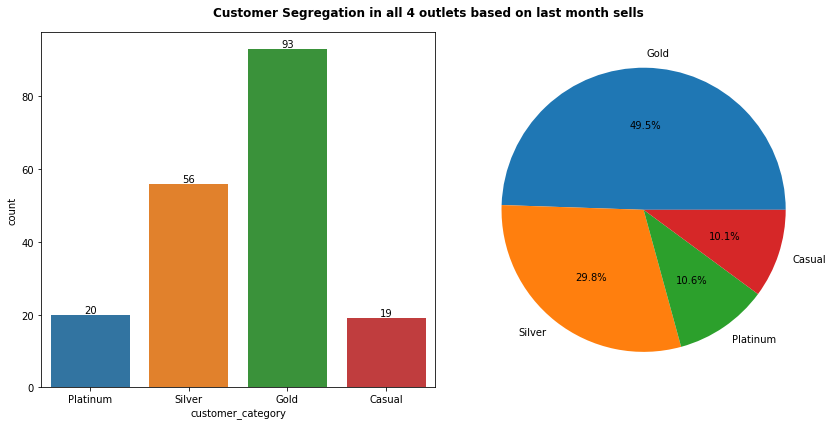

In [13]:
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle("Customer Segregation in all 4 outlets based on last month sells", weight='bold')

plt.subplot(1,2,1)
bar = sns.countplot(data=customers_df, x='customer_category')
for i in bar.containers:
    bar.bar_label(i)

plt.subplot(122)
pie = customers_df.customer_category.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')

plt.tight_layout()
plt.show()

### Q.4. Deploy a 'Low Stock' Alert mechanism

![Alert Mechanism](IMG_20220729_132021738.jpg)

In [5]:
cur.execute('CALL HyperMarket.products_stocks_info()')

stocks_df = create_df(cur)


ProgrammingError: 1305 (42000): PROCEDURE HyperMarket.products_stocks_info does not exist

In [6]:
stocks_df.head()

,product_id,quantity,Current_status
0,1,114.0,Low Stocks
1,2,194.0,Stocks Sufficient
2,3,267.0,Stocks Sufficient
3,4,250.0,Stocks Sufficient
4,5,186.0,Stocks Sufficient


In [7]:
stocks_df.Current_status.value_counts()

Stocks Sufficient    11119
Low Stocks             881
Name: Current_status, dtype: int64